<br>
First of all, I have added samples of both classes to the validation data from the training data. The validation data was very small (only 16 samples). I have used 2 pretrained models, namely Xception and InceptionV3. Lastly, I used an ensemble method using  2 models using  a weighted average layer.<br>



I used followed methods<br>
- Increased the size of the validation set <br>
- Class weights to deal with the class unbalanced problem <br>
- Data augmentation methods <br>
- Two pretrained model <br>
- Weighted average layer <br>


## References
- https://stackoverflow.com/questions/67647843/is-there-a-way-to-ensemble-two-keras-h5-models-trained-for-same-classes


In [1]:
# Importing dependencies

import warnings 
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense , Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D,ReLU, ELU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

import skimage
import cv2

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [2]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    data = []
    images = os.listdir(path)
    for i in tqdm(images, desc='images'):
        data.append(os.path.join(path, i))
        
    return data


train_data_normal = create_images_list('/kaggle/input/pneumonia-chest-x-ray-dataset/train/normal')
train_data_pneumonia = create_images_list('/kaggle/input/pneumonia-chest-x-ray-dataset/train/pneumonia')

val_data_normal = create_images_list('/kaggle/input/pneumonia-chest-x-ray-dataset/val/normal')
val_data_pneumonia = create_images_list('/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia')

test_data_normal = create_images_list('/kaggle/input/pneumonia-chest-x-ray-dataset/test/normal')
test_data_pneumonia = create_images_list('/kaggle/input/pneumonia-chest-x-ray-dataset/test/pneumonia')


# look-up table
classes = {0:'normal', 1 : 'pneumonia'}


train_df = pd.concat([ pd.DataFrame( { "img": np.array(train_data_normal[:1300]), "class": 0 }), 
                       pd.DataFrame( { "img": np.array(train_data_pneumonia[:3800]), "class": 1 })] ,ignore_index = True)

val_df = pd.concat([ pd.DataFrame({ "img": np.array(val_data_normal), "class":0 }),
                     pd.DataFrame({ "img": np.array(val_data_pneumonia) ,"class" :1}),
                     pd.DataFrame({ "img": np.array(train_data_normal[1300:]) ,"class" :0}),
                     pd.DataFrame({ "img": np.array(train_data_pneumonia[3800:]) ,"class" :1})], ignore_index = True)

test_df = pd.concat([ pd.DataFrame({"img": np.array(test_data_normal) , "class":0 }), 
                      pd.DataFrame({"img": np.array(test_data_pneumonia), "class":1 })],  ignore_index = True)


train_df = shuffle(train_df).reset_index().drop( columns = ['index'], axis = 1)
val_df = shuffle(val_df).reset_index().drop( columns = ['index'], axis = 1)
test_df = shuffle(test_df).reset_index().drop( columns = ['index'], axis = 1)

images:   0%|          | 0/1341 [00:00<?, ?it/s]

images:   0%|          | 0/3875 [00:00<?, ?it/s]

images:   0%|          | 0/8 [00:00<?, ?it/s]

images:   0%|          | 0/8 [00:00<?, ?it/s]

images:   0%|          | 0/234 [00:00<?, ?it/s]

images:   0%|          | 0/390 [00:00<?, ?it/s]

In [3]:
print("train images: ", train_df.shape[0])
print("val images: ", val_df.shape[0])
print("test images: ", test_df.shape[0])

train images:  5100
val images:  132
test images:  624


In [4]:
# Unique classes in training data

np.array(train_df['class'].value_counts())

array([3800, 1300])

In [5]:
# Calculating class weights to deal with the imbalanced problem

counts = np.bincount(train_df['class'])

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.0007692307692307692, 1: 0.0002631578947368421}

In [6]:
def img_preprocessing(image, label):
    
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (200,200))
    img = tf.cast(img, tf.float32)/255.0
    
    return img,label


In [7]:
def img_augmentation(image, label):
    
    img = tf.image.random_brightness(image, 0.1)
    img = tf.image.random_contrast(img, 0.1, 0.3)
    
    return img, label

In [8]:
BATCH_SIZE = 32

train_loader = tf.data.Dataset.from_tensor_slices((train_df['img'], train_df['class'] ))
train_dataset = (train_loader.map(img_preprocessing).map(img_augmentation).batch(BATCH_SIZE).shuffle(train_df.shape[0]).prefetch(BATCH_SIZE))

val_loader = tf.data.Dataset.from_tensor_slices((val_df['img'], val_df['class'] ))
val_dataset = (val_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(val_df.shape[0]).prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['class'] ))
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(test_df.shape[0]).prefetch(BATCH_SIZE))


# <span style="color:#e74c3c;"> Model 1: </span> Pretrained InceptionV3


In [9]:
pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False ,input_shape=[200,200, 3])
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(256),
    BatchNormalization(),
    ELU(),
    Dropout(0.15),
    
    Dense(128),
    BatchNormalization(),
    ELU(),
    Dropout(0.15),
    
    Dense(1, activation = 'sigmoid')
    
])

model.compile(optimizer  = tf.keras.optimizers.Adam(0.00001), loss = 'binary_crossentropy', metrics = ['accuracy', 'AUC', 'Precision', 'Recall'])

model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_94 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 elu (ELU)                   (None, 256)               0         
                                                         

In [10]:
my_callbacks = [ ReduceLROnPlateau(monitor='accuracy', patience = 2 , verbose=1,factor=0.3, min_lr=0.000001),
               EarlyStopping(monitor='val_loss', patience=3)]

In [11]:
hist = model.fit(train_dataset, epochs = 20 ,class_weight = class_weight, validation_data = val_dataset, callbacks = my_callbacks)

Epoch 1/20
160/160 [==============================] - 122s 405ms/step - loss: 2.0260e-04 - accuracy: 0.7141 - auc: 0.8278 - precision: 0.9089 - recall: 0.6850 - val_loss: 0.8349 - val_accuracy: 0.4924 - val_auc: 0.7792 - val_precision: 0.8636 - val_recall: 0.2289 - lr: 1.0000e-05
Epoch 2/20
160/160 [==============================] - 89s 386ms/step - loss: 1.4488e-04 - accuracy: 0.8029 - auc: 0.9308 - precision: 0.9657 - recall: 0.7626 - val_loss: 0.6995 - val_accuracy: 0.6136 - val_auc: 0.8387 - val_precision: 0.9000 - val_recall: 0.4337 - lr: 1.0000e-05
Epoch 3/20
160/160 [==============================] - 88s 387ms/step - loss: 1.2863e-04 - accuracy: 0.8282 - auc: 0.9489 - precision: 0.9765 - recall: 0.7884 - val_loss: 0.5925 - val_accuracy: 0.7348 - val_auc: 0.8689 - val_precision: 0.9286 - val_recall: 0.6265 - lr: 1.0000e-05
Epoch 4/20
160/160 [==============================] - 88s 383ms/step - loss: 1.1998e-04 - accuracy: 0.8447 - auc: 0.9570 - precision: 0.9790 - recall: 0.8089 -

In [12]:
model.save('InceptionV3_weights.h5')

In [13]:
eval_test = model.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(eval_test[1]*100))

20/20 [==============================] - 9s 280ms/step - loss: 0.3736 - accuracy: 0.8429 - auc: 0.9086 - precision: 0.8411 - recall: 0.9231
test accuracy : 84.295 %


In [14]:
pred = model.predict(test_dataset)
pred = np.round(pred)
clf_rep= classification_report(test_df['class'], pred)

print(clf_rep)

20/20 [==============================] - 6s 182ms/step
              precision    recall  f1-score   support

           0       0.32      0.26      0.29       234
           1       0.60      0.66      0.63       390

    accuracy                           0.51       624
   macro avg       0.46      0.46      0.46       624
weighted avg       0.49      0.51      0.50       624



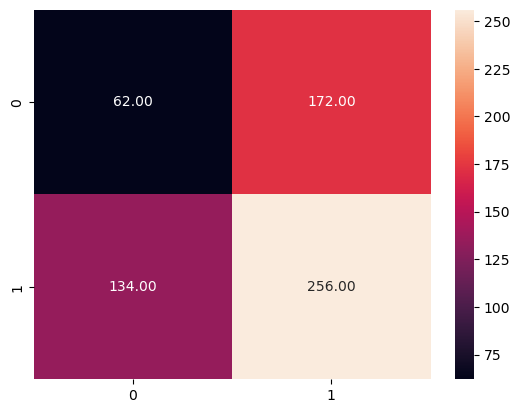

In [15]:
cm = confusion_matrix(test_df['class'], pred)
cf = sns.heatmap(cm, annot = True, fmt = '.2f' )

# <span style="color:#e74c3c;"> Model 2: </span> Pretrained Xception


In [16]:
pretrained_model2 = tf.keras.applications.Xception(weights='imagenet',include_top=False ,input_shape=[200,200, 3])
pretrained_model2.trainable = False

model2 = tf.keras.Sequential([
    pretrained_model,
    Flatten(),
    
    Dense(256),
    BatchNormalization(),
    ReLU(),
    Dropout(0.15),

    Dense(128),
    BatchNormalization(),
    ReLU(),
    Dropout(0.15),
    
    Dense(64),
    BatchNormalization(),
    ReLU(),
    Dropout(0.15),
    
    
    Dense(1, activation = 'sigmoid')
    
])

model2.compile(optimizer  = tf.keras.optimizers.Adam(0.00001) , loss = 'binary_crossentropy', metrics = ['accuracy', 'AUC', 'Precision', 'Recall'])

model2.summary()

83683744/83683744 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               8388864   
                                                                 
 batch_normalization_100 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               

In [17]:
hist2 = model2.fit(train_dataset, epochs = 20 ,class_weight = class_weight, validation_data = val_dataset, callbacks = my_callbacks)

Epoch 1/20
160/160 [==============================] - 92s 408ms/step - loss: 1.6088e-04 - accuracy: 0.7945 - auc_1: 0.9036 - precision_1: 0.9410 - recall_1: 0.7726 - val_loss: 0.6776 - val_accuracy: 0.6061 - val_auc_1: 0.9120 - val_precision_1: 0.9697 - val_recall_1: 0.3855 - lr: 1.0000e-05
Epoch 2/20
160/160 [==============================] - 90s 402ms/step - loss: 1.1048e-04 - accuracy: 0.8784 - auc_1: 0.9672 - precision_1: 0.9795 - recall_1: 0.8547 - val_loss: 0.4298 - val_accuracy: 0.8182 - val_auc_1: 0.9422 - val_precision_1: 0.9538 - val_recall_1: 0.7470 - lr: 1.0000e-05
Epoch 3/20
160/160 [==============================] - 92s 405ms/step - loss: 9.5451e-05 - accuracy: 0.9016 - auc_1: 0.9780 - precision_1: 0.9859 - recall_1: 0.8805 - val_loss: 0.3412 - val_accuracy: 0.8788 - val_auc_1: 0.9539 - val_precision_1: 0.9241 - val_recall_1: 0.8795 - lr: 1.0000e-05
Epoch 4/20
160/160 [==============================] - 91s 404ms/step - loss: 8.2170e-05 - accuracy: 0.9224 - auc_1: 0.9858 -

In [18]:
model2.save('Xception_weights.h5')

In [19]:
eval_test = model2.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(eval_test[1]*100))

20/20 [==============================] - 7s 214ms/step - loss: 0.3972 - accuracy: 0.8141 - auc_1: 0.9001 - precision_1: 0.7991 - recall_1: 0.9385
test accuracy : 81.410 %


In [20]:
pred2 = model2.predict(test_dataset)
pred2 = np.round(pred2)
clf_rep2= classification_report(test_df['class'], pred2)

print(clf_rep2)

20/20 [==============================] - 6s 186ms/step
              precision    recall  f1-score   support

           0       0.38      0.27      0.32       234
           1       0.63      0.74      0.68       390

    accuracy                           0.56       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.56      0.54       624



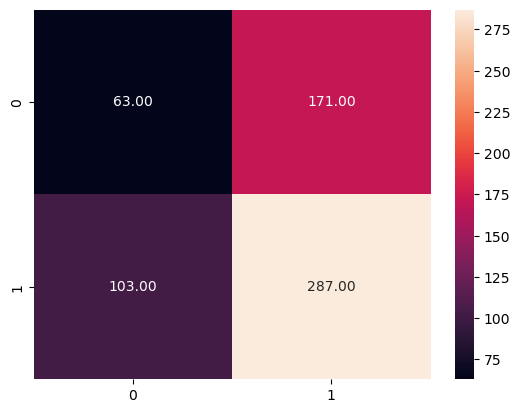

In [21]:
cm2 = confusion_matrix(test_df['class'], pred2)
cf2 = sns.heatmap(cm2, annot = True, fmt = '.2f' )

# <span style="color:#e74c3c;"> Model 3: </span> Ensemble Model


In [22]:
model1 = tf.keras.models.load_model('/kaggle/working/InceptionV3_weights.h5', compile=False)
model2 = tf.keras.models.load_model('/kaggle/working/Xception_weights.h5', compile=False)


In [23]:
# Average weighted layer from -> https://stackoverflow.com/questions/67647843/is-there-a-way-to-ensemble-two-keras-h5-models-trained-for-same-classes

class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

In [24]:
# the first model is better than the second model

models = [model1, model2]
model_input = tf.keras.Input(shape=(200,200, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = WeightedAverageLayer(0.75, 0.25)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [25]:
ensemble_model.compile(optimizer  = tf.keras.optimizers.Adam(0.00001) , loss = 'binary_crossentropy', metrics = ['accuracy', 'AUC', 'Precision', 'Recall'])

ensemble_model.summary()


hist3 = ensemble_model.fit(train_dataset, epochs = 25 ,class_weight = class_weight, validation_data = test_dataset, callbacks = my_callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 1)            22361889    ['input_3[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 1)            30234657    ['input_3[0][0]']                
                                                                                                  
 weighted_average_layer (Weight  (None, 1)           0           ['sequential[0][0]',         

In [26]:
eval_test = ensemble_model.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(eval_test[1]*100))

20/20 [==============================] - 48s 412ms/step - loss: 0.3812 - accuracy: 0.8317 - auc_2: 0.9120 - precision_2: 0.8188 - recall_2: 0.9385
test accuracy : 83.173 %


In [27]:
pred3 = ensemble_model.predict(test_dataset)
pred3 = np.round(pred3)
clf3= classification_report(test_df['class'], pred3)

print(clf3)

20/20 [==============================] - 10s 367ms/step
              precision    recall  f1-score   support

           0       0.40      0.30      0.34       234
           1       0.63      0.73      0.68       390

    accuracy                           0.57       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.57      0.55       624



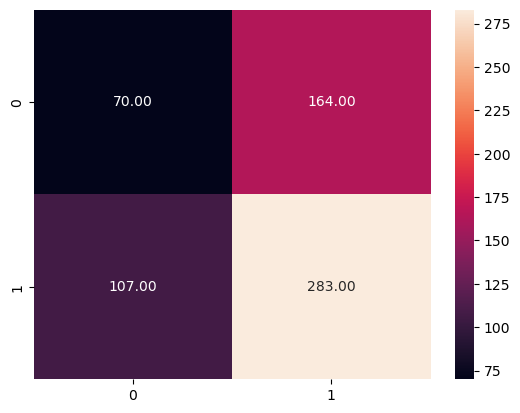

In [28]:
cm3 = confusion_matrix(test_df['class'], pred3)
cf3 = sns.heatmap(cm3, annot = True, fmt = '.2f' )